In [11]:
from tsai.basics import *
import json
import numpy as np
import fastai
import fastai.tabular
from fastai.vision.all import *


import sys 
sys.path.insert(0, '/home/gridsan/ssarangerel/mocat-ml')

from CNN import *
import matplotlib.pyplot as plt
from mocatml.utils import *
from mocatml.data import *

In [12]:
path = '/home/gridsan/ssarangerel/mocat-ml/'
with open(f'{path}data_numpy/data_config.json', "r") as outfile:
    data = json.load(outfile, strict=False)
extent = list(data['extent'])
data_numpy = np.load(f'{path}data_numpy/data.npy')

d, n_epochs, window_size, batch_size = 128, 35, 60, 8192
num_sim, split = 100, 0.9

model_name = f'd_{d}_epoch_{n_epochs}_split_{split}'
AE = torch.load(f'{path}models/{model_name}.pt')

In [17]:
with open(f'{path}models/indices_{model_name}.txt', "r") as f:
    
    indices = f.read().split()
    
split = float(indices[0])
indices = [int(i) for i in indices[1:]]

train_indices = indices[:int(split * num_sim)]
val_indices = indices[int(split * num_sim):]

In [18]:
data_enc = []
for i in range(num_sim):
    encoded = model.encrypt(torch.tensor(data_numpy[i], dtype=torch.float32).unsqueeze(0).transpose(0, 1))
    data_enc.append(encoded.detach().numpy())
data_enc = np.array(data_enc)
data_enc.shape

(100, 2436, 128)

In [19]:
sh = data_enc.shape
data_enc_reshaped = data_enc.reshape((sh[0], sh[-1], sh[1]))
X_train, y_train = apply_sliding_window_3d(data_enc_reshaped[train_indices], 
                                           window_len=window_size,
                                           stride=1,
                                           seq_first=False,
                                           horizon=1)
X_valid, y_valid = apply_sliding_window_3d(data_enc_reshaped[val_indices], 
                                           window_len=window_size,
                                           stride=1,
                                           seq_first=False,
                                           horizon=1)

X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
X.shape, y.shape, splits

((237600, 128, 60),
 (237600, 128, 1),
 ((#213840) [0,1,2,3,4,5,6,7,8,9...],
  (#23760) [213840,213841,213842,213843,213844,213845,213846,213847,213848,213849...]))

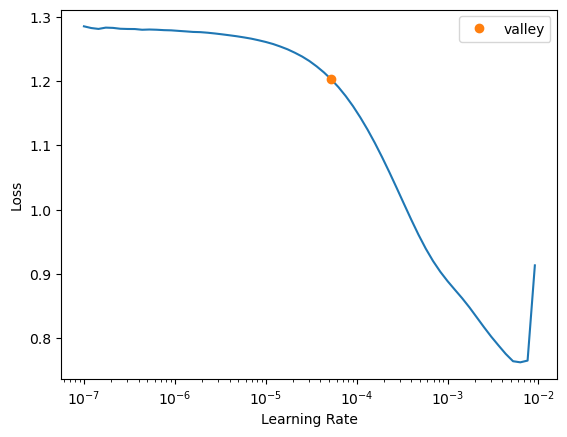

In [20]:
model_name = "TSTPlus"
learn = TSForecaster(X, y, splits, bs=batch_size, arch=model_name)
lr = learn.lr_find().valley

epoch,train_loss,valid_loss,time
0,1.236476,1.123294,00:15
1,1.181462,1.066611,00:15
2,1.113657,0.963159,00:15
3,1.029567,0.841074,00:15
4,0.928751,0.706779,00:15
5,0.814026,0.569342,00:15
6,0.691083,0.438778,00:15
7,0.567688,0.324171,00:15
8,0.451465,0.230807,00:15
9,0.348459,0.159874,00:15


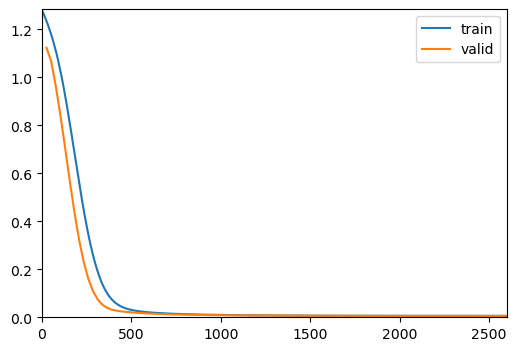

In [21]:
epochs = 100
learn.fit_one_cycle(epochs, lr, cbs=[ShowGraphCallback()])

In [22]:
interp_train = Interpretation.from_learner(learn, 0)
interp_val = Interpretation.from_learner(learn, 1)

In [23]:
largest_loss_train, smallest_loss_train = interp_train.top_losses(1, largest = False), interp_train.top_losses(1)
largest_loss_val, smallest_loss_val = interp_val.top_losses(1, largest = False), interp_val.top_losses(1)

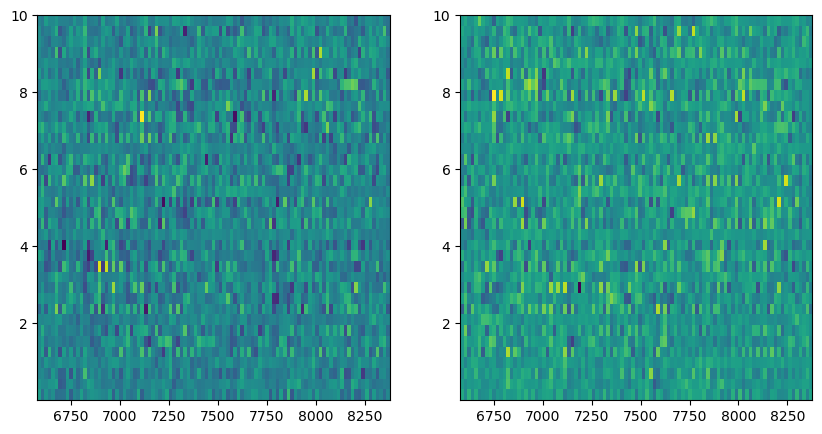

In [26]:
idx_train, idx_val = largest_loss_train[1].item(), largest_loss_val[1].item()
recon_train = model.decrypt(torch.tensor(y[idx_train].T[0]))[0]
recon_val = model.decrypt(torch.tensor(y[idx_val].T[0]))[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(recon_train.detach().numpy(), extent = extent, aspect = 'auto')
axs[1].imshow(recon_val.detach().numpy(), extent = extent, aspect = 'auto')
plt.show()
plt.close(fig)

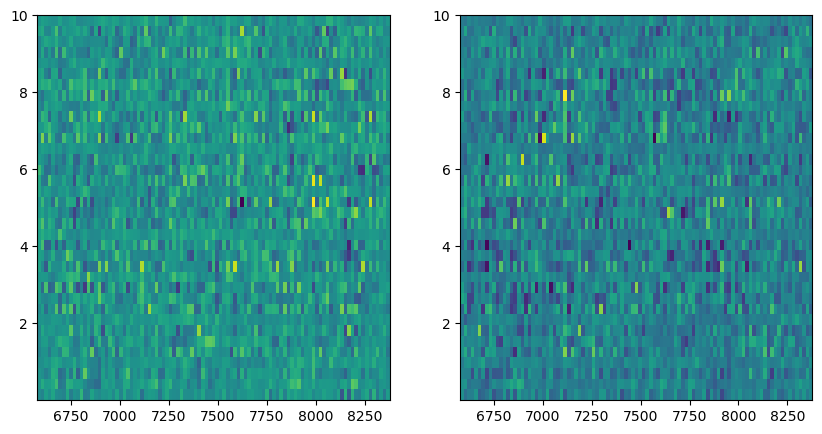

In [27]:
idx_train, idx_val = smallest_loss_train[1].item(), smallest_loss_val[1].item()
recon_train = model.decrypt(torch.tensor(y[idx_train].T[0]))[0]
recon_val = model.decrypt(torch.tensor(y[idx_val].T[0]))[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(recon_train.detach().numpy(), extent = extent, aspect = 'auto')
axs[1].imshow(recon_val.detach().numpy(), extent = extent, aspect = 'auto')
plt.show()
plt.close(fig)

In [28]:
learn.export(f'time_model/{model_name}_d_{d}_epoch_{epochs}.pkl')

RuntimeError: Parent directory time_model does not exist.